In [3]:
import torch
import spacy
import string
import pandas as pd
import numpy as np
import pickle as pkl
import random
import time
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import os
root = '/Users/nhungle/Desktop/Submission'


In [5]:
# Import data
train_snli = pd.read_csv(os.path.join(root, "data/snli_train.tsv"), sep="\t")
val_snli = pd.read_csv(os.path.join(root,"data/snli_val.tsv"), sep="\t")



In [6]:
# Check number of observations
print("Number of observations in the training set: %d" % len(train_snli))
print("Number of observations in the validation set: %d" % len(val_snli))


Number of observations in the training set: 100000
Number of observations in the validation set: 1000


In [7]:
# Check class composition
print("Class composition in the training set:\n{}".format(train_snli["label"].value_counts()))
print("Class composition in the validation set:\n{}".format(val_snli["label"].value_counts()))

Class composition in the training set:
entailment       33635
neutral          33200
contradiction    33165
Name: label, dtype: int64
Class composition in the validation set:
neutral          338
contradiction    331
entailment       331
Name: label, dtype: int64


## 1. Data Preprocessing
#### 1.1 Tokenize sentences
Tokenize premise and hypothesis in the training set and the validation set

In [8]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Create tokenizer
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    # Track tokenize observations
    token_dataset = []
    # Track tokens
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [9]:
# Import train tokens
train_data_premise_tokens = pkl.load(open(os.path.join(root, "data/snli_train_premise_tokens.p"), "rb"))
all_train_premise_tokens = pkl.load(open(os.path.join(root, "data/snli_all_train_premise_tokens.p"), "rb"))
train_data_hypothesis_tokens = pkl.load(open(os.path.join(root, "data/snli_train_hypothesis_tokens.p"), "rb"))
all_train_hypothesis_tokens = pkl.load(open(os.path.join(root, "data/snli_all_train_hypothesis_tokens.p"), "rb"))

# Import test tokens
val_data_premise_tokens = pkl.load(open(os.path.join(root, "data/snli_val_premise_tokens.p"), "rb"))
all_val_premise_tokens = pkl.load(open(os.path.join(root, "data/snli_all_val_premise_tokens.p"), "rb"))
val_data_hypothesis_tokens = pkl.load(open(os.path.join(root, "data/snli_val_hypothesis_tokens.p"), "rb"))
all_val_hypothesis_tokens = pkl.load(open(os.path.join(root, "data/snli_all_val_hypothesis_tokens.p"), "rb"))

#### Please use the saved tokens and skip the following part:

In [ ]:
# # Tokenize training data
# train_data_premise_tokens, all_train_premise_tokens = tokenize_dataset(train_snli["sentence1"])
# pkl.dump(train_data_premise_tokens, open("snli_train_premise_tokens.p", "wb"))
# pkl.dump(all_train_premise_tokens, open("snli_all_train_premise_tokens.p", "wb"))

# train_data_hypothesis_tokens, all_train_hypothesis_tokens = tokenize_dataset(train_snli["sentence2"])
# pkl.dump(train_data_hypothesis_tokens, open("snli_train_hypothesis_tokens.p", "wb"))
# pkl.dump(all_train_hypothesis_tokens, open("snli_all_train_hypothesis_tokens.p", "wb"))

# # Tokenize validation data
# val_data_premise_tokens, all_val_premise_tokens = tokenize_dataset(val_snli["sentence1"])
# pkl.dump(val_data_premise_tokens, open("snli_val_premise_tokens.p", "wb"))
# pkl.dump(all_val_premise_tokens, open("snli_all_val_premise_tokens.p", "wb"))

# val_data_hypothesis_tokens, all_val_hypothesis_tokens = tokenize_dataset(val_snli["sentence2"])
# pkl.dump(val_data_hypothesis_tokens, open("snli_val_hypothesis_tokens.p", "wb"))
# pkl.dump(all_val_hypothesis_tokens, open("snli_all_val_hypothesis_tokens.p", "wb"))

In [7]:
# Check token size
print ("Train premise dataset size is {}".format(len(train_data_premise_tokens)))
print ("Train hypothesis dataset size is {}".format(len(train_data_hypothesis_tokens)))
print ("Validation premise dataset size is {}".format(len(val_data_premise_tokens)))
print ("Validation hypothesis dataset size is {}".format(len(val_data_hypothesis_tokens)))

print ("Total number of tokens in train premise dataset is {}".format(len(all_train_premise_tokens)))
print ("Total number of tokens in train hypothesis dataset is {}".format(len(all_train_hypothesis_tokens)))
print ("Total number of tokens in validation premise dataset is {}".format(len(all_val_premise_tokens)))
print ("Total number of tokens in validation hypothesis dataset is {}".format(len(all_val_hypothesis_tokens)))

Train premise dataset size is 100000
Train hypothesis dataset size is 100000
Validation premise dataset size is 1000
Validation hypothesis dataset size is 1000
Total number of tokens in train premise dataset is 1294135
Total number of tokens in train hypothesis dataset is 743372
Total number of tokens in validation premise dataset is 14057
Total number of tokens in validation hypothesis dataset is 7614


#### 1.2 Convert the most common tokens to ID

In [10]:
# Index 0 for special token <unk>
PAD_IDX = 0
# Index 1 for special token <pad>
UNK_IDX = 1

# Create the vocabulary of the most common tokens in the training set
def build_vocab(all_tokens, 
                vocab_size = 10000):
    """
    Input:
    all_tokens:       all tokens in the dataset
    max_vocab_size:   the vocabulary size
    
    Output:
    id2token:   list of tokens, where id2token[i] returns token that corresponds to token i
    token2id:   dictionary where keys represent tokens and corresponding values represent indices
    """
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2, 2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# Convert token to id in the dataset
def token2index_dataset(tokens_data,
                       token2id):
    """
    Input:
    tokens_data:    tokens in the dataset
    token2id:       dictionary where keys represent tokens and corresponding values represent indices
    
    Output:
    indices_data:   indices representing tokens in the dataset
    """
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

def token2index_all(vocab_size):
    # Create vocabulary for all training sentences
    all_train_token = all_train_premise_tokens + all_train_hypothesis_tokens
    token2id, id2token = build_vocab(all_tokens = all_train_token, 
                                     vocab_size = vocab_size)

    # Convert tokens in premise and hypothesis in the training set into indices
    train_premise_ind = token2index_dataset(train_data_premise_tokens, token2id)
    train_hypothesis_ind = token2index_dataset(train_data_hypothesis_tokens, token2id)

    # Convert tokens in premise and hypothesis in the validation set into indices
    val_premise_ind = token2index_dataset(val_data_premise_tokens, token2id)
    val_hypothesis_ind = token2index_dataset(val_data_hypothesis_tokens, token2id)
    
    return token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind

In [11]:
# Use vocab size = 10000 for baseline
token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind = token2index_all(10000)

# Check token to index
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 4600 ; token chimney
Token chimney; token id 4600


#### 1.3 Create PyTorch DataLoader

In [12]:
# Check average sentence length
print(f'The average number of tokens in premise is {np.mean([len(i) for i in train_data_premise_tokens])}')
print(f'The average number of tokens in hypothesis is {np.mean([len(i) for i in train_data_hypothesis_tokens])}')

The average number of tokens in premise is 12.94135
The average number of tokens in hypothesis is 7.43372


In [13]:
# Set max sentence length as 10 as the average number of token is around 13
MAX_SENTENCE_LENGTH = 10
# Set batch size
BATCH_SIZE = 128

# Create SNLIDataset class for DataLoader
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    """
    def __init__(self, premise, hypothesis, labels):
        """
        Input:
        data_list: list of tokens 
        target_list: list of target label
        """
        self.premise = premise
        self.hypothesis = hypothesis
        # Convert string label to integer
        self.labels = labels.replace({'entailment': 0, 'neutral': 1, 'contradiction': 2})
        assert (len(self.premise) == len(self.hypothesis))
        assert (len(self.premise) == len(self.labels))
        
    def __len__(self):
        return len(self.premise)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """ 
        premise_idx = self.premise[key][:MAX_SENTENCE_LENGTH]
        hypothesis_idx = self.hypothesis[key][:MAX_SENTENCE_LENGTH]
        label = self.labels[key]
        return [premise_idx, len(premise_idx), hypothesis_idx, len(hypothesis_idx), label]
    
# Create collate function for fixed length representation
def snli_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    premise_list = []
    premise_len_list = []
    hypothesis_list= []
    hypothesis_len_list = []
    label_list = []
    for datum in batch:
        label_list.append(datum[-1])
        premise_len_list.append(datum[1])
        hypothesis_len_list.append(datum[3])
    # Add padding
    for datum in batch:
        padded_premise = np.pad(np.array(datum[0]),
                               pad_width = ((0, MAX_SENTENCE_LENGTH-datum[1])),
                               mode="constant", constant_values = 0)
        premise_list.append(padded_premise)
        
        padded_hypothesis = np.pad(np.array(datum[2]),
                               pad_width = ((0, MAX_SENTENCE_LENGTH-datum[3])),
                               mode="constant", constant_values = 0)
        hypothesis_list.append(padded_hypothesis)
        
    return [torch.from_numpy(np.array(premise_list)), 
            torch.LongTensor(premise_len_list), 
            torch.from_numpy(np.array(hypothesis_list)), 
            torch.LongTensor(hypothesis_len_list), 
            torch.LongTensor(label_list)]

In [14]:
# Create SNLIDataset classes
train_dataset = SNLIDataset(train_premise_ind, train_hypothesis_ind, train_snli["label"])
val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=snli_collate_func,
                                           shuffle=True)

## 2. SNLI Modeling

#### 2.1 Baseline Models
The baseline model uses the following parameters:
- Vocabulary size = 10000 (excluding two special tokens for `pad` and `unk`) 
- Embedding dimension = 100
- Interaction method = `concat`

#### 2.1.1 Logistic Regression

In [15]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, 
                 vocab_size, 
                 emb_dim, 
                 interaction,
                 neural_net = False,
                 hidden_dim1 = None,
                 hidden_dim2 = None):
        """
        Input:
        vocab_size:   size of the vocabulary
        emb_dim:      size of the word embedding
        interaction:  interaction methods for two representations
        neural_net:   whether to build a neural network with two hidden layers or a logistic
                      regression model
        hidden_dim1:  dimension of the first hidden layer of neural net
        hidden_dim2:  dimension of the second hidden layer of neural net
        """
        super(BagOfWords, self).__init__()
        # Pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.interaction = interaction
        self.neural_net = neural_net
        # Set linear dimension based on interaction methods and model types
        # Neural network with two hidden layers
        if neural_net:
            if interaction == 'concat':
                self.first_layer = nn.Linear(2*emb_dim, hidden_dim1)
            else:
                self.first_layer = nn.Linear(emb_dim, hidden_dim1)
            self.second_layer = nn.Linear(hidden_dim1, hidden_dim2)
            self.last_linear = nn.Linear(hidden_dim2, 3)
        # Logistic regression
        else:
            if interaction == 'concat':
                self.linear = nn.Linear(2*emb_dim,3)
            else:
                self.linear = nn.Linear(emb_dim,3)

    def forward(self, premise, p_length, hypothesis, h_length):
        """
        Input: 
        premise:     matrix of size (batch_size, max_sentence_length). 
                     Each row in data is a premise represented by index in the same length
        p_length:    an int tensor of size (batch_size)
        hypothesis:  matrix of size (batch_size, max_sentence_length). 
                     Each row in data is a hypothesis represented by index in the same length
        h_length:    an int tensor of size (batch_size)
        """
        p_out = self.embed(premise)
        p_out = torch.sum(p_out, dim=1)
        p_out /= p_length.view(p_length.size()[0],1).expand_as(p_out).float()
     
        h_out = self.embed(hypothesis)
        h_out = torch.sum(h_out, dim=1)
        h_out /= h_length.view(h_length.size()[0],1).expand_as(h_out).float()
        
        # Combine two representations
        out = self.interaction_func(p_out, h_out)
        if self.neural_net:
            out = F.relu(self.first_layer(out.float()))
            out = F.relu(self.second_layer(out))
            out = self.last_linear(out)
        else:
            out = self.linear(out.float())
        return out
    
    # Interact premise with hypothesis using method specified
    def interaction_func(self, premise, hypothesis):
        """
        Input: 
        premise:     matrix of size (batch_size, max_sentence_length). 
                     Each row in data is a premise represented by index in the same length
        hypothesis:  matrix of size (batch_size, max_sentence_length). 
                     Each row in data is a hypothesis represented by index in the same length
        
        Output:
        A matrix that represents the combination of premise and hypothesis
        """
        if self.interaction == 'concat':
            return torch.cat((premise, hypothesis), dim = 1)
        elif self.interaction == 'sum':
            return (premise + hypothesis)
        elif self.interaction == 'element_wise_product':
            return (premise * hypothesis)

In [16]:
# Function for testing the model
def test_model(loader, model):
    """
    Test the model's performance on a dataset
    Input:
    loader: DataLoader for the dataset to test against
    model:  trained model
    """
    correct = 0
    total = 0
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    for premise, p_length, hypothesis, h_length, labels in loader:
        outputs = model(premise, p_length, hypothesis, h_length)
        loss = criterion(outputs, labels)
        predicted = F.softmax(outputs, dim=1).max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return loss, (100 * correct / total)

def train_and_val(train_loader, 
                  val_loader, 
                  model, 
                  num_epochs,
                  verbose = False):
    """
    Train model and test model performance on the validation set
    Input:
    train_loader: DataLoader for training data
    val_loader:   DataLoader for validation data
    model:        model to be trained
    num_empochs:  number of epochs
    """
    start = time.time()
    # Model Parameter
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Keep track of accuracy and loss history
    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    
    for epoch in range(num_epochs):
        for i, (premise, p_length, hypothesis, h_length, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(premise, p_length, hypothesis, h_length)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if verbose:
                if i % 150 == 0:
                    print(f'Epoch: [{epoch+1}/{num_epochs}], Step: [{i+1}/{len(train_loader)}], Train Loss: {loss:.4f}')

                # Validate every 100 iterations
                if i > 0 and i % 250 == 0:
                    # Validate
                    val_loss, val_acc = test_model(val_loader, model)
                    print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}, Validation Acc: {}'.format( 
                               epoch+1, num_epochs, i+1, len(train_loader), loss, val_loss, val_acc))
                        
        # Track loss and accuracy for each epoch
        # Compute final stat for training and validation sets
        train_loss, train_acc = test_model(train_loader, model)
        val_loss, val_acc = test_model(val_loader, model)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        if verbose:
            print('-'*50)
    print()
    print('Final Stats:')
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Loss: {:.4f}, Train Accuracy: {}".format(train_loss, train_acc))
    print ("Val loss: {:.4f}, Val Acc: {}".format(val_loss, val_acc))
    print(f'Total training time: {time.time() - start}')
    hist = [train_loss_hist,  val_loss_hist, train_acc_hist, val_acc_hist]
    return model, val_loss, val_acc, train_loss, train_acc, hist

In [17]:
# Implement BoW for logistic regression
logreg_baseline = BagOfWords(vocab_size = len(id2token), 
                   emb_dim = 100, 
                   interaction = 'concat')

# Train and validate model
logreg_baseline, val_loss, val_acc, \
    train_loss, train_acc, hist = train_and_val(train_loader = train_loader, 
                                                  val_loader = val_loader, 
                                                  model = logreg_baseline, 
                                                  num_epochs = 10,
                                                  verbose = True)

Epoch: [1/10], Step: [1/782], Train Loss: 1.1157
Epoch: [1/10], Step: [151/782], Train Loss: 1.0402
Epoch: [1/10], Step: [251/782], Train Loss: 0.9773, Validation Loss: 1.0669, Validation Acc: 50.0
Epoch: [1/10], Step: [301/782], Train Loss: 0.9733
Epoch: [1/10], Step: [451/782], Train Loss: 1.0237
Epoch: [1/10], Step: [501/782], Train Loss: 0.9285, Validation Loss: 1.0080, Validation Acc: 54.7
Epoch: [1/10], Step: [601/782], Train Loss: 0.9243
Epoch: [1/10], Step: [751/782], Train Loss: 0.9233
Epoch: [1/10], Step: [751/782], Train Loss: 0.9233, Validation Loss: 0.9761, Validation Acc: 57.1
--------------------------------------------------
Epoch: [2/10], Step: [1/782], Train Loss: 0.8763
Epoch: [2/10], Step: [151/782], Train Loss: 0.8987
Epoch: [2/10], Step: [251/782], Train Loss: 0.8701, Validation Loss: 0.9071, Validation Acc: 59.3
Epoch: [2/10], Step: [301/782], Train Loss: 0.9532
Epoch: [2/10], Step: [451/782], Train Loss: 0.8102
Epoch: [2/10], Step: [501/782], Train Loss: 0.9313,

KeyboardInterrupt: 

#### 2.1.2 Neural Network

In [16]:
emb_dim = 100
hidden_dim1 = 50
hidden_dim2 = 25
nn_baseline = BagOfWords(len(id2token), emb_dim, 'concat', True, hidden_dim1, hidden_dim2)

# Train and validate model
nn_baseline, val_loss, val_acc, \
    train_loss, train_acc, hist = train_and_val(train_loader = train_loader, 
                                                  val_loader = val_loader, 
                                                  model = nn_baseline, 
                                                  num_epochs = 10,
                                                  verbose = True)

Epoch: [1/10], Step: [1/782], Train Loss: 1.1098
Epoch: [1/10], Step: [151/782], Train Loss: 1.0152
Epoch: [1/10], Step: [251/782], Train Loss: 0.9207, Validation Loss: 1.0111, Validation Acc: 50.0
Epoch: [1/10], Step: [301/782], Train Loss: 1.0043
Epoch: [1/10], Step: [451/782], Train Loss: 0.8889
Epoch: [1/10], Step: [501/782], Train Loss: 0.9883, Validation Loss: 0.9036, Validation Acc: 54.9
Epoch: [1/10], Step: [601/782], Train Loss: 0.8957
Epoch: [1/10], Step: [751/782], Train Loss: 0.9897
Epoch: [1/10], Step: [751/782], Train Loss: 0.9897, Validation Loss: 0.8437, Validation Acc: 57.1
--------------------------------------------------
Epoch: [2/10], Step: [1/782], Train Loss: 0.8838
Epoch: [2/10], Step: [151/782], Train Loss: 0.8191
Epoch: [2/10], Step: [251/782], Train Loss: 0.8114, Validation Loss: 0.9326, Validation Acc: 59.5
Epoch: [2/10], Step: [301/782], Train Loss: 0.9380
Epoch: [2/10], Step: [451/782], Train Loss: 0.8916
Epoch: [2/10], Step: [501/782], Train Loss: 0.8738,

#### 2.2 Hyperparameter Tuning
We want to fine-tune the following hyperparameters:
- Interction methods (concat, sum, point-wise product)
- Size of vocabulary
- Embedding dimension

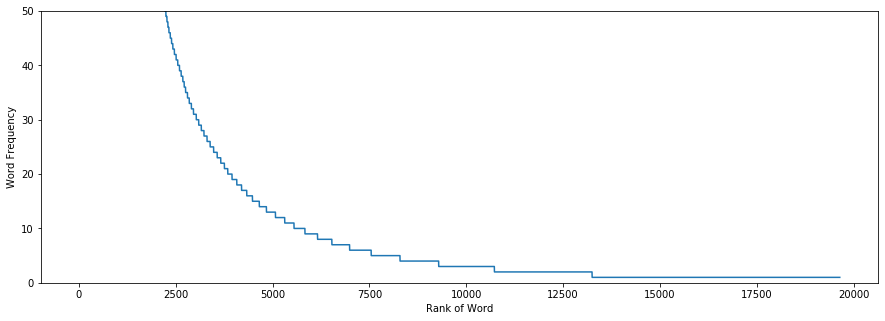

In [57]:
# Check word frequency
token_counter = Counter(all_train_premise_tokens + all_train_hypothesis_tokens)
token_counter_df = pd.DataFrame \
                    .from_dict(token_counter, orient = "index") \
                    .rename(columns = {"index": "token", 0 : "frequency"}) \
                    .sort_values(by = "frequency", ascending = False) \
                    .reset_index()
# Visualize word frequency
plt.figure(figsize=(15,5))
plt.plot(token_counter_df.index, token_counter_df["frequency"])
plt.xlabel("Rank of Word")
plt.ylabel("Word Frequency")
plt.ylim(0, 50)
plt.show()

#### 2.2.1 Tuning Logistic Regression Model

In [18]:
vocab_size_list = [2500 * i for i in range(3, 7)]
embed_dim_list = [25 * i for i in range(3, 7)]
interaction_list = ['concat', 'sum', 'element_wise_product']
logreg_result = []
best_logreg = None
best_hist = None

In [102]:
for v in vocab_size_list:
    for e in embed_dim_list:
        for i in interaction_list:
            print("Vocabulary size : {}".format(v))
            print("Embedding dimension : {}".format(e))
            print("Interaction method: {}".format(i))
            # Convert vocabulary to indices
            token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind = token2index_all(v)

            # Create SNLIDataset classes
            train_dataset = SNLIDataset(train_premise_ind, train_hypothesis_ind, train_snli["label"])
            val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])

            # Create DataLoaders
            train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                       batch_size=BATCH_SIZE,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)
            val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                       batch_size=BATCH_SIZE,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)

            # Implement BoW for logistic regression
            logreg = BagOfWords(vocab_size = v+2, 
                                emb_dim = e, 
                                interaction = i)

            # Train and validate model
            logreg, val_loss, val_acc, \
                train_loss, train_acc, hist = train_and_val(train_loader = train_loader, 
                                                              val_loader = val_loader, 
                                                              model = logreg, 
                                                              num_epochs = 10,
                                                              verbose = False)
            # Check the number of trained parameter
            num_param = sum(p.numel() for p in logreg.parameters())
            
            logreg_result.append([v, e, i, val_loss, val_acc, train_loss, train_acc, num_param, hist])
            print('-'*50)
            # Check if the current model returns the lowest validation loss
            if val_acc == max(x[4] for x in logreg_result):
                best_logreg = logreg
                best_hist = hist

Vocabulary size : 7500
Embedding dimension : 75
Interaction method: concat

Final Stats:
After training for 10 epochs
Train Loss: 0.8696, Train Accuracy: 67.631
Val loss: 0.9005, Val Acc: 60.3
Total training time: 226.63303899765015
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 75
Interaction method: sum

Final Stats:
After training for 10 epochs
Train Loss: 0.9105, Train Accuracy: 61.365
Val loss: 0.9737, Val Acc: 56.3
Total training time: 226.33495903015137
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 75
Interaction method: element_wise_product

Final Stats:
After training for 10 epochs
Train Loss: 0.5266, Train Accuracy: 71.015
Val loss: 1.0058, Val Acc: 61.3
Total training time: 225.4711880683899
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 100
Interaction method: concat

Final Stats:
After training for 10 epochs
Train Loss: 0.8277,

In [139]:
# Save the best model
#torch.save(best_logreg.state_dict(), 'models/best_logreg.pth')

In [133]:
# Check dimension
best_logreg

BagOfWords(
  (embed): Embedding(15002, 125, padding_idx=0)
  (linear): Linear(in_features=125, out_features=3, bias=True)
)

In [45]:
# Models sorted by validation accuracy
logreg_df = pd.DataFrame.from_dict(logreg_result[:7]) \
                        .rename(columns = {0: "vocab_size", 1: "embed_dim",
                                            2: "interaction", 3: "val_loss", 
                                            4: "val_acc", 5: "train_loss", 
                                           6: "train_acc", 7: "num_param"}) \
                        .sort_values("val_acc", ascending = False)

In [41]:
# Table for all metrics
logreg_df

,vocab_size,embed_dim,interaction,val_loss,val_acc,train_loss,train_acc,num_param
44,15000,125,element_wise_product,0.8788,63.3,0.5244,77.020,1875628
23,10000,150,element_wise_product,0.9010,62.3,0.7439,77.310,1500753
39,15000,100,concat,0.8670,62.0,0.3704,69.818,1500803
41,15000,100,element_wise_product,0.7595,61.8,0.6102,74.638,1500503
42,15000,125,concat,0.9107,61.7,0.6820,70.279,1876003
15,10000,100,concat,0.9066,61.4,0.7784,68.989,1000803
20,10000,125,element_wise_product,0.7950,61.3,0.5700,75.422,1250628
2,7500,75,element_wise_product,1.0058,61.3,0.5266,71.015,562878
36,15000,75,concat,0.9225,61.3,0.9157,69.126,1125603
24,12500,75,concat,0.8591,61.2,0.5515,68.854,938103


In [40]:
# Table for all metrics
logreg_df = logreg_df.sort_values("val_acc", ascending = False)

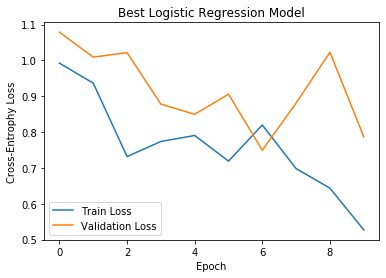

In [67]:
# Create visualizations for the best model
plt.plot(best_hist[0], label = "Train Loss")
plt.plot(best_hist[1], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entrophy Loss")
plt.title("Best Logistic Regression Model")
plt.legend()
plt.show()

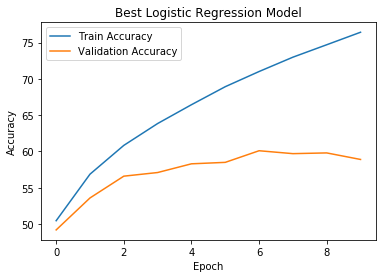

In [68]:
# Create visualizations for the best model
plt.plot(hist[2], label = "Train Accuracy")
plt.plot(hist[3], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Best Logistic Regression Model")
plt.legend()
plt.show()

In [174]:
# Check predictions
# Create validation DataLoader for 100 observations
token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind = token2index_all(15000)
val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=len(val_dataset),
                                           collate_fn=snli_collate_func,
                                           shuffle=False)
# Create prediction
best_logreg.eval()
for premise, p_length, hypothesis, h_length, labels in val_loader:
    outputs = best_logreg(premise, p_length, hypothesis, h_length)
    predicted = F.softmax(outputs, dim=1).max(1, keepdim=True)[1] 
    actual_labels = labels.numpy()
    predicted_labels = np.hstack(predicted.numpy())

# Check first three correct predictions
# {'entailment': 0, 'neutral': 1, 'contradiction': 2}
for i in np.where(actual_labels == predicted_labels)[0][:3]:
    premise = np.array(id2token)[val_dataset.premise[i]]
    hypothesis = np.array(id2token)[val_dataset.hypothesis[i]]
    print("Premise: {}".format(" ".join(premise)))
    print("Hypothesis: {}".format(" ".join(hypothesis)))
    print("Label: {}".format(actual_labels[i]))
    print()

Premise: three women on a stage one wearing red shoes black pants and a gray shirt is sitting on a prop another is sitting on the floor and the third wearing a black shirt and pants is standing as a gentleman in the back tunes an instrument
Hypothesis: there are two women standing on the stage
Label: 2

Premise: four people sit on a subway two read books one looks at a cellphone and is wearing knee high boots
Hypothesis: multiple people are on a subway together with each of them doing their own thing
Label: 0

Premise: bicycles stationed while a group of people socialize
Hypothesis: people get together near a stand of bicycles
Label: 0



In [172]:
# Check first three incorrect predictions
# {'entailment': 0, 'neutral': 1, 'contradiction': 2}
for i in np.where(actual_labels != predicted_labels)[0][:3]:
    premise = np.array(id2token)[val_dataset.premise[i]]
    hypothesis = np.array(id2token)[val_dataset.hypothesis[i]]
    print("Premise: {}".format(" ".join(premise)))
    print("Hypothesis: {}".format(" ".join(hypothesis)))
    print("Label: {}".format(actual_labels[i]))
    print("Prediction: {}".format(predicted_labels[i]))
    print()

Premise: two people are in a green forest
Hypothesis: the forest is not dead
Label: 0
Prediction: 2

Premise: two women one walking her dog the other pushing a stroller
Hypothesis: there is a snowstorm
Label: 2
Prediction: 0

Premise: three people and a white dog are sitting in the sand on a beach
Hypothesis: three dogs and a person are sitting in the snow
Label: 2
Prediction: 0



#### 2.2.2 Tuning Neural Network

In [20]:
# Fixed dimension for hidden layers
hidden_dim1 = 50
hidden_dim2 = 25

# Tuning parameters
vocab_size_list = [2500 * i for i in range(3, 7)]
embed_dim_list = [25 * i for i in range(3, 7)]
interaction_list = ['concat', 'sum', 'element_wise_product']
nn_result = []
best_nn = None
best_hist = None

In [121]:
for v in vocab_size_list:
    for e in embed_dim_list:
        for i in interaction_list:
            print("Vocabulary size : {}".format(v))
            print("Embedding dimension : {}".format(e))
            print("Interaction method: {}".format(i))
            # Convert vocabulary to indices
            token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind = token2index_all(v)

            # Create SNLIDataset classes
            train_dataset = SNLIDataset(train_premise_ind, train_hypothesis_ind, train_snli["label"])
            val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])

            # Create DataLoaders
            train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                       batch_size=BATCH_SIZE,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)
            val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                       batch_size=BATCH_SIZE,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)

            # Implement BoW for logistic regression
            neural_net = BagOfWords(vocab_size = v+2, 
                                    emb_dim = e, 
                                    interaction = i, 
                                    neural_net = True,
                                    hidden_dim1 = hidden_dim1, 
                                    hidden_dim2 = hidden_dim2)

            # Train and validate model
            neural_net, val_loss, val_acc, \
                train_loss, train_acc, hist = train_and_val(train_loader = train_loader, 
                                                          val_loader = val_loader, 
                                                          model = neural_net, 
                                                          num_epochs = 10,
                                                          verbose = False)
            # Check the number of trained parameter
            num_param = sum(p.numel() for p in neural_net.parameters())
            
            nn_result.append([v, e, i, val_loss, val_acc, train_loss, train_acc, num_param, hist])
            print('-'*50)
            # Check if the current model returns the lowest validation loss
            if val_acc == max(x[4] for x in nn_result):
                best_nn = neural_net
                best_hist = hist

Vocabulary size : 7500
Embedding dimension : 75
Interaction method: concat

Final Stats:
After training for 10 epochs
Train Loss: 0.3723, Train Accuracy: 76.218
Val loss: 0.8953, Val Acc: 61.8
Total training time: 279.19124603271484
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 75
Interaction method: sum

Final Stats:
After training for 10 epochs
Train Loss: 0.7365, Train Accuracy: 69.117
Val loss: 0.8903, Val Acc: 59.6
Total training time: 288.26658296585083
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 75
Interaction method: element_wise_product

Final Stats:
After training for 10 epochs
Train Loss: 0.5287, Train Accuracy: 74.25
Val loss: 0.9020, Val Acc: 58.4
Total training time: 287.1514208316803
--------------------------------------------------
Vocabulary size : 7500
Embedding dimension : 100
Interaction method: concat

Final Stats:
After training for 10 epochs
Train Loss: 0.4901, 

In [123]:
torch.save(best_nn.state_dict(), 'models/best_nn.pth')

In [130]:
# Check dimension
best_nn

BagOfWords(
  (embed): Embedding(10002, 150, padding_idx=0)
  (first_layer): Linear(in_features=300, out_features=50, bias=True)
  (second_layer): Linear(in_features=50, out_features=25, bias=True)
  (last_linear): Linear(in_features=25, out_features=3, bias=True)
)

In [126]:
# Models sorted by validation accuracy
nn_df = pd.DataFrame.from_dict(nn_result[:7]) \
                    .rename(columns = {0: "vocab_size", 1: "embed_dim",
                                        2: "interaction", 3: "val_loss", 
                                        4: "val_acc", 5: "train_loss", 
                                       6: "train_acc", 7:"num_param"}) \
                    .sort_values("val_acc", ascending = False)

In [66]:
# Table for all metrics
nn_df

,vocab_size,embed_dim,interaction,val_loss,val_acc,train_loss,train_acc,num_param
21,10000,150,concat,0.8085,65.2,0.5450,82.233,1516703
18,10000,125,concat,0.6839,65.0,0.5931,80.474,1264153
6,7500,125,concat,0.9152,64.8,0.3412,79.453,951653
27,12500,100,concat,0.8546,64.7,0.6646,79.851,1261603
12,10000,75,concat,0.8291,64.7,0.4850,77.745,759053
24,12500,75,concat,0.6562,64.6,0.6237,77.027,946553
42,15000,125,concat,1.0046,63.9,0.4040,81.398,1889153
15,10000,100,concat,0.9262,63.7,0.5839,79.350,1011603
45,15000,150,concat,1.0073,63.6,0.3949,82.933,2266703
9,7500,150,concat,0.7687,63.4,0.4178,79.063,1141703


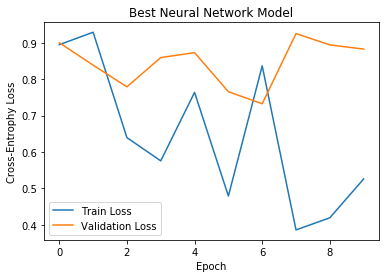

In [92]:
# Create visualizations for the best model
plt.plot(best_hist[0], label = "Train Loss")
plt.plot(best_hist[1], label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entrophy Loss")
plt.title("Best Neural Network Model")
plt.legend()
plt.show()

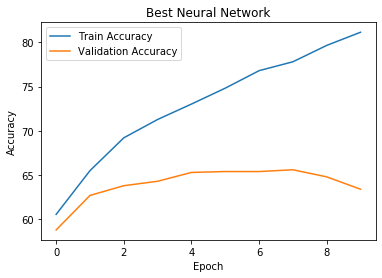

In [93]:
plt.plot(hist[2], label = "Train Accuracy")
plt.plot(hist[3], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Best Neural Network")
plt.legend()
plt.show()

In [184]:
# Check predictions
# Create validation DataLoader for 100 observations
token2id, id2token, train_premise_ind, train_hypothesis_ind, val_premise_ind, val_hypothesis_ind = token2index_all(10000)
val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=len(val_dataset),
                                           collate_fn=snli_collate_func,
                                           shuffle=False)
# Create prediction
best_nn.eval()
for premise, p_length, hypothesis, h_length, labels in val_loader:
    outputs = best_nn(premise, p_length, hypothesis, h_length)
    predicted = F.softmax(outputs, dim=1).max(1, keepdim=True)[1] 
    actual_labels = labels.numpy()
    predicted_labels = np.hstack(predicted.numpy())

# Check first three correct predictions
# {'entailment': 0, 'neutral': 1, 'contradiction': 2}
for i in np.where(actual_labels == predicted_labels)[0][:3]:
    premise = np.array(id2token)[val_dataset.premise[i]]
    hypothesis = np.array(id2token)[val_dataset.hypothesis[i]]
    print("Premise: {}".format(" ".join(premise)))
    print("Hypothesis: {}".format(" ".join(hypothesis)))
    print("Label: {}".format(actual_labels[i]))
    print()

Premise: four people sit on a subway two read books one looks at a cellphone and is wearing knee high boots
Hypothesis: multiple people are on a subway together with each of them doing their own thing
Label: 0

Premise: man in overalls with two horses
Hypothesis: a man in overalls with two horses
Label: 0

Premise: two men are listening to music through headphones
Hypothesis: two men listen to music
Label: 0



In [185]:
# Check first three incorrect predictions
# {'entailment': 0, 'neutral': 1, 'contradiction': 2}
for i in np.where(actual_labels != predicted_labels)[0][:3]:
    premise = np.array(id2token)[val_dataset.premise[i]]
    hypothesis = np.array(id2token)[val_dataset.hypothesis[i]]
    print("Premise: {}".format(" ".join(premise)))
    print("Hypothesis: {}".format(" ".join(hypothesis)))
    print("Label: {}".format(actual_labels[i]))
    print("Prediction: {}".format(predicted_labels[i]))
    print()

Premise: three women on a stage one wearing red shoes black pants and a gray shirt is sitting on a prop another is sitting on the floor and the third wearing a black shirt and pants is standing as a gentleman in the back tunes an instrument
Hypothesis: there are two women standing on the stage
Label: 2
Prediction: 0

Premise: bicycles stationed while a group of people socialize
Hypothesis: people get together near a stand of bicycles
Label: 0
Prediction: 2

Premise: man observes a <unk> given off by an electronic device
Hypothesis: the man is examining what <unk> is given off by the device
Label: 0
Prediction: 2



#### 2.3 Best Models
#### 2.3.1 Best Logistic Regression Model

In [42]:
# Parameters
best_logreg_path = os.path.join(root, 'models/best_logreg.pth')
best_logreg_embed_dim = 125
best_logreg_interaction = 'element_wise_product'

# Load saved tokens
token2id = pkl.load(open('tokens/logreg_token2id.p', 'rb'))
id2token = pkl.load(open('tokens/logreg_id2token.p', 'rb'))
# Load saved model
best_logreg = BagOfWords(vocab_size = len(id2token), 
                                emb_dim = best_logreg_embed_dim, 
                                interaction = best_logreg_interaction)

best_logreg.load_state_dict(torch.load(best_logreg_path))
best_logreg.eval()

# Recreate the validation set
# Convert tokens in premise and hypothesis in the validation set into indices
val_premise_ind = token2index_dataset(val_data_premise_tokens, token2id)
val_hypothesis_ind = token2index_dataset(val_data_hypothesis_tokens, token2id)
# Create SNLIDataset
val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])
# Create DataLoader
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                       batch_size=128,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)

# Evaluate on validation set
val_loss, val_acc = test_model(val_loader, best_logreg)

#### 2.3.2 Neural Network


In [18]:
# Parameters
best_nn_path = os.path.join(root, 'models/best_nn.pth')
best_nn_embed_dim = 150
best_nn_interaction = 'concat'

# Load saved tokens
token2id = pkl.load(open('tokens/nn_token2id.p', 'rb'))
id2token = pkl.load(open('tokens/nn_id2token.p', 'rb'))
# Load saved model
best_nn = BagOfWords(vocab_size = len(id2token), 
                                emb_dim = best_nn_embed_dim, 
                                interaction = best_nn_interaction,
                                neural_net = True,
                                hidden_dim1 = 50, 
                                hidden_dim2 = 25)

best_nn.load_state_dict(torch.load(best_nn_path))
best_nn.eval()

# Recreate the validation set
# Convert tokens in premise and hypothesis in the validation set into indices
val_premise_ind = token2index_dataset(val_data_premise_tokens, token2id)
val_hypothesis_ind = token2index_dataset(val_data_hypothesis_tokens, token2id)
# Create SNLIDataset
val_dataset = SNLIDataset(val_premise_ind, val_hypothesis_ind, val_snli["label"])
# Create DataLoader
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                       batch_size=128,
                                                       collate_fn=snli_collate_func,
                                                       shuffle=True)

# Evaluate on validation set
val_loss, val_acc = test_model(val_loader, best_nn)
val_acc

FileNotFoundError: [Errno 2] No such file or directory: 'tokens/nn_token2id.p'